# Preprocessor with Negation-tagging

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
from collections import Counter
from nltk import FreqDist

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
# Set constant variables
label_mapping = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 100) 

In [3]:
# Set paths
script_dir = os.path.dirname(os.path.abspath('processor_neg.ipynb'))
data_path = os.path.join(script_dir, 'Thesis_Jupyter_Final/src/')
os.getcwd()
print(data_path)

input_folder_path = os.path.join(data_path, 'input')
processed_folder_path = os.path.join(data_path, 'input/processed')
processed_normal_folder_path = os.path.join(data_path, 'input/processed/normal')
processed_neg_folder_path = os.path.join(data_path, 'input/processed/neg_tagged')

clean_data_filename = "clean_data_NEG.csv"
folder_path = processed_neg_folder_path

/home2/s3985113/Thesis_Jupyter_Final/src/


# Load Data

In [4]:
loaded_clean_df =  pd.read_csv(os.path.join(folder_path, clean_data_filename))
loaded_clean_df.set_index('Id', inplace=True, drop=True)

print(loaded_clean_df.info())
print()
print(f'Dataset shape: {loaded_clean_df.shape}\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106987 entries, 0 to 106986
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     106987 non-null  object
 1   Sentiment  106987 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None

Dataset shape: (106987, 2)



# Analysis Functions

In [5]:
def print_senti_counts(counts):
    """
    Print the number of reviews per sentiment and their percentage.

    Args:
        counts (dict): A dictionary containing sentiment counts. The keys represent sentiment labels
                       and the values represent the corresponding counts.

    Returns:
        None
    """
        
    total_count = sum(counts)
    for senti, count in counts.items():
        sentiment_name = label_mapping[senti]
        percent = (count / total_count) * 100
        print(f"{senti} ({sentiment_name}): {count} reviews ({percent:.2f}%)")


def plot_senti_counts(counts, df_type):
    """
    Plot counts per sentiment.

    Args:
        counts (list): A list containing sentiment counts.
        df_type (str): The type of data (e.g., "General") for which the sentiment distribution is plotted.

    Returns:
        None
    """
        
    colors = ['limegreen', 'dodgerblue', 'red']
    plt.pie(counts, colors=colors, autopct='%1.1f%%',  pctdistance=0.8, textprops={'fontsize': 10, 'color': 'black'}, startangle=90)
    plt.axis('equal')  # pie as a circle
    plt.legend(labels=list(label_mapping.values())[::-1], loc='lower left')
    plt.title(f"Sentiment Distribution in {df_type} data")
    plt.show()

def count_words(text):
    """
    Count words per review.

    Args:
        text (str): The text representing a review.

    Returns:
        int: The number of words in the review.
    """
     
    return len(str(text).split(' '))

def analyse_data(df_x, df_y, df_type, plot=True):
    """
    Call all the data analysis functions alltogether.

    Args:
        df_x (DataFrame): A DataFrame containing the review data.
        df_y (DataFrame): A DataFrame containing the sentiment labels.
        df_type (str): The type of data (e.g., "General") being analyzed.
        plot (bool, optional): Whether to plot the sentiment counts. Defaults is True.

    Returns:
        None
    """
    
    print(f"Analyzing {df_type} data")
    
    senti_counts = df_y.value_counts()
    print_senti_counts(senti_counts)
    if plot:
        plot_senti_counts(senti_counts, df_type)

    # Calculate total and average word count without adding a new column to the dataframe
    total_word_count = df_x.apply(count_words).sum()
    avg_review_len = df_x.apply(count_words).mean()

    print("Total word count: ", total_word_count)
    print(f"Average review length: {avg_review_len:.2f}\n")

## Split train and test

In [6]:
def print_split_dist(x_train, x_val, x_test):
    """
    Print the distribution of data split sizes.

    Args:
        x_train (array): Training data.
        x_val (array): Validation data.
        x_test (array): Testing data.

    Returns:
        None
    """

    x_train_size = len(x_train)
    x_val_size = len(x_val)
    x_test_size = len(x_test)

    total = x_train_size + x_val_size + x_test_size
    print("Data Distribution:")
    print(f"*train: {x_train_size} ({(x_train_size / total) * 100:.2f}%)")
    print(f"*val: {x_val_size} ({(x_val_size / total) * 100:.2f}%)")
    print(f"*test: {x_test_size} ({(x_test_size / total) * 100:.2f}%)")
    print()

In [7]:
def split_train_test(review_col, sentiment_col):
    """
    Split the dataset into training, validation, and test sets.

    Args:
        review_col (DataFrame): A Pandas Series containing the review data.
        sentiment_col (DataFrame): A Pandas Series containing the sentiment labels.

    Returns:
        Tuple of DataFrame: x_train, y_train, x_val, y_val, x_test, y_test
    """
    
    # Split dataset into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(review_col, sentiment_col, stratify=sentiment_col, test_size=0.2, random_state=42) # Stratify ensures proportional sampling
    # Split the training dataset further into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

    print_split_dist(x_train, x_val, x_test)

    return x_train, y_train, x_val, y_val, x_test, y_test


x_train, y_train, x_val, y_val, x_test, y_test = split_train_test(loaded_clean_df['Review'], loaded_clean_df['Sentiment'])

analyse_data(x_train, y_train, "Training", plot=False)
analyse_data(x_val, y_val, "Validation", plot=False)
analyse_data(x_test, y_test, "Testing", plot=False)

Data Distribution:
*train: 68471 (64.00%)
*val: 17118 (16.00%)
*test: 21398 (20.00%)

Analyzing Training data
3 (Positive): 62208 reviews (90.85%)
2 (Neutral): 3245 reviews (4.74%)
1 (Negative): 3018 reviews (4.41%)
Total word count:  908178
Average review length: 13.26

Analyzing Validation data
3 (Positive): 15552 reviews (90.85%)
2 (Neutral): 811 reviews (4.74%)
1 (Negative): 755 reviews (4.41%)
Total word count:  228249
Average review length: 13.33

Analyzing Testing data
3 (Positive): 19441 reviews (90.85%)
2 (Neutral): 1014 reviews (4.74%)
1 (Negative): 943 reviews (4.41%)
Total word count:  286560
Average review length: 13.39



In [8]:
# Check split data
x_train.head(100)

Id
13522                                                                                  awesome helpful course
86366     took longer hoped complete course satisfying finish dr chuck appreciate passion dedication teach...
89832                                                                                good introduction python
65107     good introduction rail well organized structured course totally worth beginner intermediate rubyist
11488     well structured thoughtful course delivered true expert subject one finest course available thro...
106741    found course good introduction review beginner writer also experienced writer need refresher sor...
74389     course well structured auto grader really streamlines course enjoyed dr chuck explanation lectur...
35075                                                                                like though finished_NEG
53637                                                                      really nice course starter ai algo
81174  

## Create, Analyse and Filter Vocabulary

### Analysis Functions

In [9]:
def plot_word_freq_cdf(word_counts, min_cutoff, max_cutoff):
    """
    Plot the cumulative distribution function (CDF) of word frequencies.

    Args:
        word_counts (array): Frequencies of words.
        min_cutoff (int): Minimum word rank cutoff for visualization.
        max_cutoff (int): Maximum word rank cutoff for visualization.

    Returns:
        None
    """

    # Calculate the cumulative sum of the sorted frequencies & normalize
    cumu_counts = np.cumsum(word_counts)
    cdf = cumu_counts / cumu_counts[-1]

    # Plot the CDF
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(1, len(cdf) + 1), cdf)
    plt.axvline(x=min_cutoff, color='r', linestyle='--')
    plt.axvline(x=max_cutoff, color='r', linestyle='--')
    plt.xlabel('Word Rank')
    plt.ylabel('Cumulative Frequency')
    plt.title('CDF of Word Frequencies')
    plt.grid(True)
    plt.show()


def calculate_word_statistics(freqs):
    """
    Calculate and print various statistics of word frequencies.

    Args:
        freqs (array): Frequencies of words.

    Returns:
        None
    """

    print("Mean frequency: ", np.mean(freqs))
    print("Median frequency: ", np.median(freqs))
    print("Max frequency: ", max(freqs))
    print("Min frequency: ", min(freqs))
    print("Standard deviation: ", np.std(freqs))
    print("1st quartile: ", np.percentile(freqs, 25))
    print("3rd quartile: ", np.percentile(freqs, 75))

def plot_word_freq_hist(word_counts):
    """
    Plot the histogram of word frequencies with a logarithmic scale.

    Args:
        word_counts (array): Frequencies of words.

    Returns:
        None
    """
    
    plt.figure(figsize=(10, 5))
    plt.hist(word_counts, bins=range(1, 500, 10), alpha=0.5)
    plt.yscale('log')
    plt.title('Word Frequency Distribution (Logarithmic Scale)')
    plt.xlabel('Word Frequency')
    plt.ylabel('Number of Words')


def plot_word_freq_most_common(dataset, labels=None, num_most_common=50, per_class=False):        
    """
    Plot the frequency distribution of the most common tokens in the dataset.

    Args:
        dataset (list): List of text data.
        labels (list or None, optional): List of labels corresponding to the dataset. Default is None.
        num_most_common (int, optional): Number of most common tokens to plot. Defaults is 50.
        per_class (bool, optional): Whether to plot separately for each class. Defaults is False.

    Returns:
        None
    """
    
    if per_class:
        class_words = {}
        # Combine dataset and labels into one list for processing
        for review, label in zip(dataset, labels):
            if label not in class_words:
                class_words[label] = []
            class_words[label].extend(review.split())
            
        for class_label, words in class_words.items():
            fdist = FreqDist(words)
            plt.figure(figsize=(10, 5))
            fdist.plot(num_most_common, title=f'Frequency Distribution of Most Common {num_most_common} Tokens in Class {label_mapping[class_label]}')
            plt.show()
    else:
        all_words = [word for review in dataset for word in review.split()]
        fdist = FreqDist(all_words)
        plt.figure(figsize=(10, 5))
        fdist.plot(num_most_common, title=f'Frequency Distribution of Most Common {num_most_common} Tokens')
        plt.show()

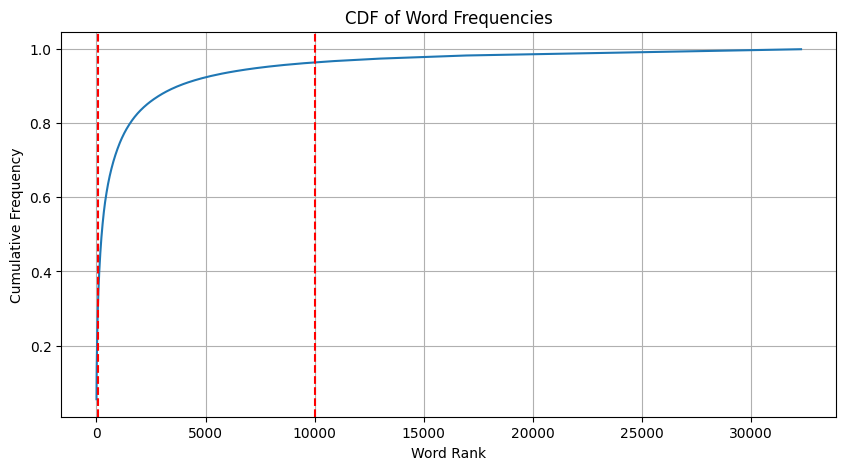

Min Freq: 4
Max Freq: 2167



In [10]:
def create_vocab(data, min_cutoff, max_cutoff):
    """
    Create a vocabulary by filtering words based on their frequency in the training set.

    Args:
        data (list): List of text data.
        min_cutoff (int): Minimum rank cutoff for word frequency.
        max_cutoff (int): Maximum rank cutoff for word frequency.

    Returns:
        original_vocab (Counter): Original vocabulary containing word frequencies.
        vocab (dict): Filtered vocabulary with words and their frequencies.
        vocab_size (int): Size of the filtered vocabulary.
    """
    
    # Calculate frequency of words in the training set
    original_vocab = Counter()
    for review in data:
        original_vocab.update(review.split())
    
    # Calculate cdf
    counts = np.array(list(original_vocab.values()))
    counts_sorted = np.sort(counts)[::-1] # descending
    plot_word_freq_cdf(counts_sorted, min_cutoff, max_cutoff)

    # Convert the cutoff values in terms of rank to the actual frequency values
    min_freq = counts_sorted[max_rank_cutoff - 1]  # -1 since 0-based indexing
    max_freq = counts_sorted[min_rank_cutoff - 1] 
    print(f"Min Freq: {min_freq}\nMax Freq: {max_freq}\n")

    # Filter vocabulary by removing words with frequency less than a set minimum frequency
    vocab = {token: freq for token, freq in original_vocab.items() if min_freq <= freq <= max_freq}
    vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True))
    vocab_size = len(vocab)
    
    # Save vocab freqs to visaulise and check vocabulary
    vocab_data_filename = "vocab.txt"
    file_path = os.path.join(folder_path, vocab_data_filename)
    with open(file_path, 'w') as f:
        for token, freq in vocab.items():
            f.write(f"{token}\t{freq}\n")

    # Save vocab as pickle to save memory space
    vocab_data_filename = "vocab.pkl"
    file_path = os.path.join(folder_path, vocab_data_filename)
    with open(file_path, 'wb') as f:
        pickle.dump(vocab, f)


    return original_vocab, vocab, vocab_size

# VOCAB-CONSTANTS
min_rank_cutoff = 50
max_rank_cutoff = 10000

original_vocab, vocab, vocab_size = create_vocab(x_train, min_rank_cutoff, max_rank_cutoff)

Mean frequency:  28.108263695450326
Median frequency:  2.0
Max frequency:  50054
Min frequency:  1
Standard deviation:  348.06788868170514
1st quartile:  1.0
3rd quartile:  6.0
After filtering, vocabulary size of 32310 reduced to 10573.

--Filtered Vocab--
10 Most Common Words:
	thing: 2167
	get: 2149
	example: 2115
	data: 2114
	amazing: 2100
	new: 2092
	informative: 2074
	python: 2071
	beginner: 2053
	machine: 2023

Mean frequency:  59.959046628203915
Median frequency:  12.0
Max frequency:  2167
Min frequency:  4
Standard deviation:  171.92226892761605
1st quartile:  6.0
3rd quartile:  36.0


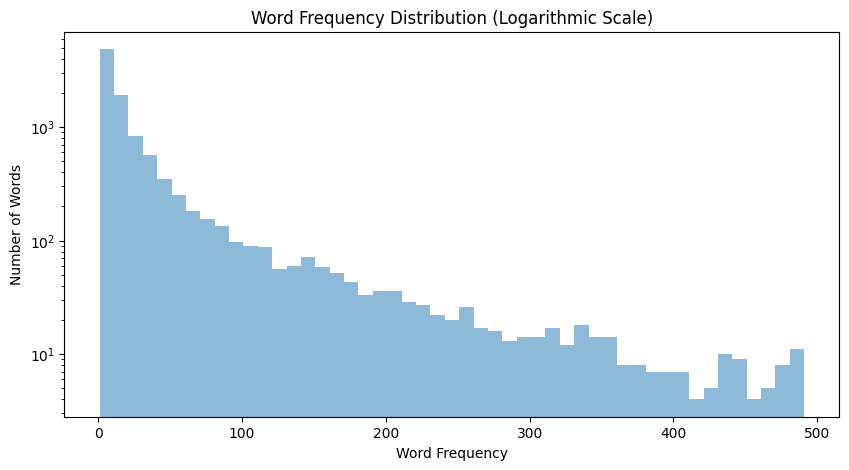

In [11]:
def analyze_vocab(original_vocab, vocab, vocab_size):
    """
    Analyze and print statistics of the original and filtered vocabularies.

    Args:
        original_vocab (Counter): Original vocabulary containing word frequencies.
        vocab (dict): Filtered vocabulary with words and their frequencies.
        vocab_size (int): Size of the filtered vocabulary.

    Returns:
        None
    """
    
    # Analyse original vocabulary
    calculate_word_statistics(np.array(list(original_vocab.values())))
    print("After filtering, vocabulary size of {} reduced to {}.\n".format(len(original_vocab), vocab_size))

    # Analyse filtered vocabulary
    print("--Filtered Vocab--")
    first_10 = list(vocab.items())[:10]
    print("10 Most Common Words:")
    for word, freq in first_10:
        print(f"\t{word}: {freq}")
    print()

    freqs = np.array(list(vocab.values()))
    calculate_word_statistics(freqs)
    plot_word_freq_hist(freqs)


analyze_vocab(original_vocab, vocab, vocab_size)

The provided code for histogram implementation has been influenced by the implementation available at the following Kaggle link: [Word Frequency Histogram](https://www.kaggle.com/code/pamin2222/tf-idf-svm-exploration).

## Filter data with vocabulary

In [12]:
def merge_data(x, y):
    """
    Merge the target and label input and target datasets together.

    Args:
        x (DataFrame): The input dataset.
        y (DataFrame): The target dataset.

    Returns:
        DataFrame: The merged dataset.
    """

    merged = pd.concat([x, y], axis=1)
    merged.columns = ['x', 'y']
    
    return merged


def filter_and_drop_empty_rows(x_data, y_data, vocab):
    """
    Filter and drop empty rows from the dataset based on a inputted vocabulary.

    Args:
        x_data (DataFrame): The input data.
        y_data (DataFrame): The target data.
        vocab (list): The vocabulary.

    Returns:
        Series: Filtered input data.
        Series: Filtered target data.
    """

    # Filter dataset based on vocabulary
    filtered_dataset = []
    for doc in x_data:
        filtered_text = ' '.join([word for word in doc.split() if word in vocab])
        filtered_dataset.append(filtered_text)

    filtered_dataset = pd.Series(filtered_dataset, index=x_data.index)
    
    # Save the filtered data
    with open("filt.txt", "w") as f:
        for item in filtered_dataset[:100]:
            f.write("%s\n" % item)
    
    # Merge filtered dataset and target data, and drop empty rows
    merged = merge_data(filtered_dataset, y_data)
    
    merged.replace('', np.nan, inplace=True)
    merged.dropna(subset=['x'], inplace=True) # TODO: subset?

    # Re-assign x and y datasets
    x_filtered = merged['x']
    y_filtered = merged['y']

    # Save the empty data
    with open("empty.txt", "w") as f:
        for item in x_filtered[:100]:
            f.write("%s\n" % item)

    return x_filtered, y_filtered


x_train, y_train = filter_and_drop_empty_rows(x_train, y_train, vocab)
x_val, y_val = filter_and_drop_empty_rows(x_val, y_val, vocab)
x_test, y_test = filter_and_drop_empty_rows(x_test, y_test, vocab)
print_split_dist(x_train, x_val, x_test)

Data Distribution:
*train: 62555 (64.01%)
*val: 15636 (16.00%)
*test: 19537 (19.99%)



Training Data: 


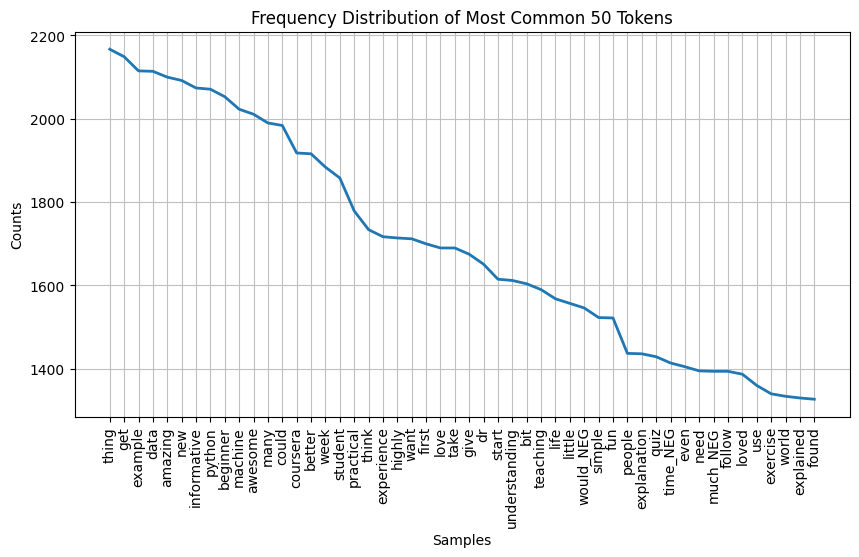

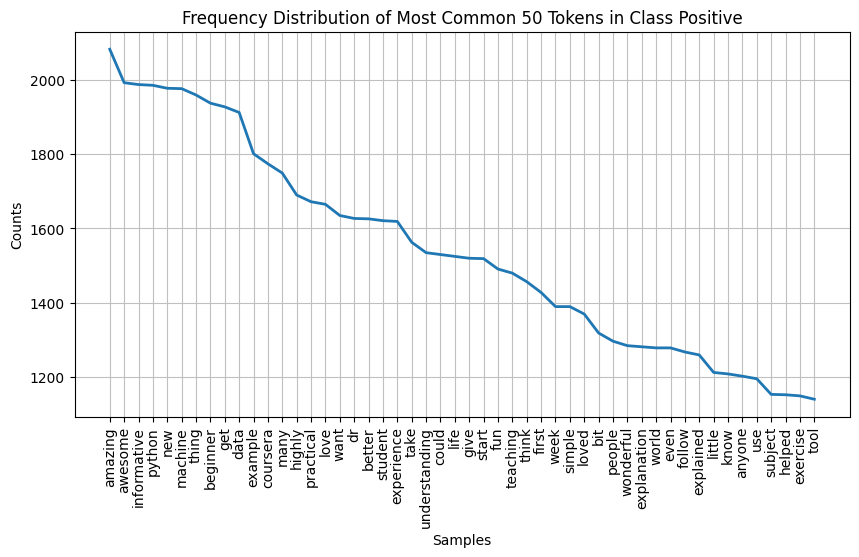

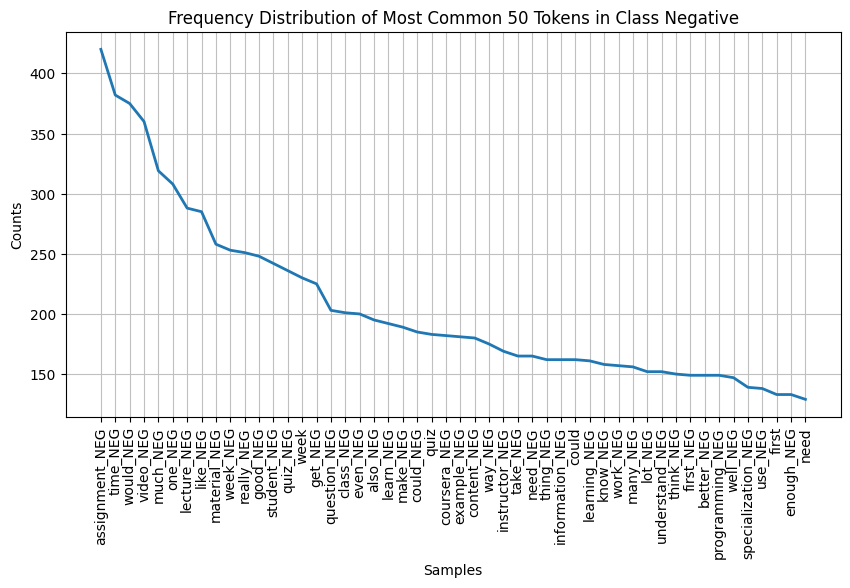

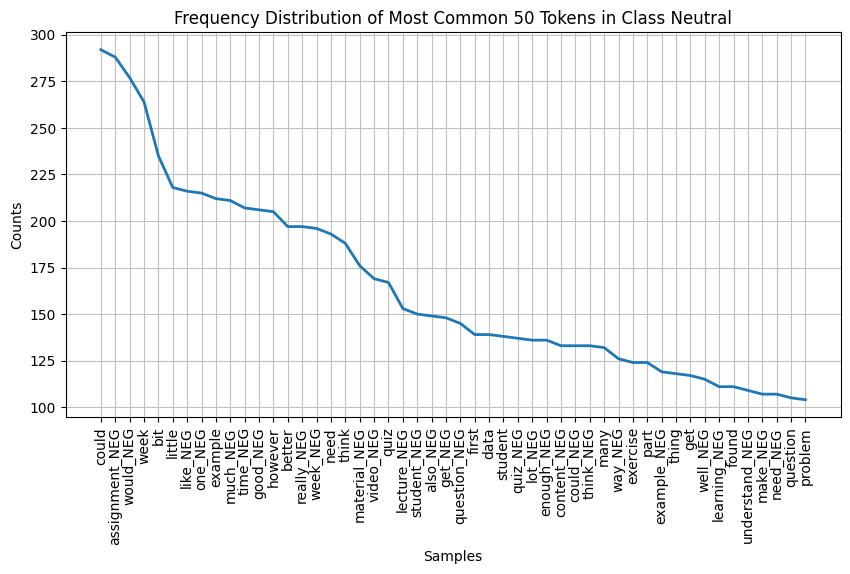

In [13]:
def analyse_train_data(x_train, y_train):
    """
    Analyze the training data.

    Args:
        x_train (DataFrame): Training data (review part).
        y_train (DataFrame): Corresponding labels or sentiments for the training data.

    Returns:
        None
    """

    print("Training Data: ")
    plot_word_freq_most_common(x_train)
    plot_word_freq_most_common(x_train, labels=y_train, num_most_common=50, per_class=True)

analyse_train_data(x_train, y_train)

## Before Balancing

In [14]:
print_split_dist(x_train, x_val, x_test)
analyse_data(x_train, y_train, "Training", plot=False)
analyse_data(x_val, y_val, "Validation", plot=False)
analyse_data(x_test, y_test, "Testing", plot=False)

Data Distribution:
*train: 62555 (64.01%)
*val: 15636 (16.00%)
*test: 19537 (19.99%)

Analyzing Training data
3 (Positive): 56390 reviews (90.14%)
2 (Neutral): 3177 reviews (5.08%)
1 (Negative): 2988 reviews (4.78%)
Total word count:  633947
Average review length: 10.13

Analyzing Validation data
3 (Positive): 14096 reviews (90.15%)
2 (Neutral): 790 reviews (5.05%)
1 (Negative): 750 reviews (4.80%)
Total word count:  157543
Average review length: 10.08

Analyzing Testing data
3 (Positive): 17616 reviews (90.17%)
2 (Neutral): 991 reviews (5.07%)
1 (Negative): 930 reviews (4.76%)
Total word count:  198722
Average review length: 10.17



# Balance Data

## Remove Postive Reviews < 3

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 50) 

def remove_pos_under_3(x_train, y_train):
    """
    Remove rows with word counts under 3 or sentiment label equal to 3 from the training data.

    Args:
        x_train (array): Training data.
        y_train (array): Training labels.

    Returns:
        x_train_filtered (DataFrame): Filtered training data.
        y_train_filtered (DataFrame): Filtered training labels.
    """

    df_train = merge_data(x_train, y_train)

    df_train['word_counts'] = df_train['x'].apply(lambda x: len(x.split()))

    # Filter rows based on the condition
    df_train = df_train[(df_train['word_counts'] > 3) | (df_train['y'] != 3)]

    # Split the DataFrame back into x_train and y_train
    x_train_filtered = df_train['x']
    y_train_filtered = df_train['y']

    return x_train_filtered, y_train_filtered


x_train_no_short_maj, y_train_no_short_maj = remove_pos_under_3(x_train, y_train)
print_split_dist(x_train_no_short_maj, x_val, x_test)
analyse_data(x_train_no_short_maj, y_train_no_short_maj, "Training", plot=False)

Data Distribution:
*train: 43662 (55.38%)
*val: 15636 (19.83%)
*test: 19537 (24.78%)

Analyzing Training data
3 (Positive): 37497 reviews (85.88%)
2 (Neutral): 3177 reviews (7.28%)
1 (Negative): 2988 reviews (6.84%)
Total word count:  597730
Average review length: 13.69



## Under & Over Sample Training Data

The code provided below draws inspiration from the article on Machine Learning Mastery titled "Random Oversampling and Undersampling for Imbalanced Classification" available at the link: [Undersampling and Oversampling Strategies](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/).

In [16]:
over_to = {1: 10500, 2: 10500} # Over-sample minority classes 
under_to = {3: 20000} # Under-sample majority class

# Define pipeline
over_sampler = RandomOverSampler(sampling_strategy=over_to)
under_sampler = RandomUnderSampler(sampling_strategy=under_to)
pipeline = Pipeline(steps=[('o', over_sampler), ('u', under_sampler)])

# Applying the pipline to both x and y datasets
x_train_balanced, y_train_balanced = pipeline.fit_resample(pd.DataFrame(x_train_no_short_maj), y_train_no_short_maj)

# Print the new class distribution
counter = Counter(y_train_balanced)
print(counter)
print(x_train_balanced.shape, y_train_balanced.shape)

Counter({3: 20000, 1: 10500, 2: 10500})
(41000, 1) (41000,)


## Under-sample Positive Reviews in Validation and Test Data

In [17]:
under_to = {3: 10000} # Under-sample majority class

# Define pipeline
under_sampler = RandomUnderSampler(sampling_strategy=under_to)

# Applying the pipeline to both x and y datasets
x_val_undersampled, y_val_undersampled = under_sampler.fit_resample(pd.DataFrame(x_val), y_val)
x_test_undersampled, y_test_undersampled = under_sampler.fit_resample(pd.DataFrame(x_test), y_test)

# Print the new class distribution
print(Counter(y_val_undersampled))
print(Counter(y_test_undersampled))

print(x_val_undersampled.shape, y_val_undersampled.shape)
print(x_test_undersampled.shape, y_test_undersampled.shape)

Counter({3: 10000, 2: 790, 1: 750})
Counter({3: 10000, 2: 991, 1: 930})
(11540, 1) (11540,)
(11921, 1) (11921,)


Data Distribution:
*train: 41000 (63.60%)
*val: 11540 (17.90%)
*test: 11921 (18.49%)

Analyzing Training data
3 (Positive): 20000 reviews (48.78%)
1 (Negative): 10500 reviews (25.61%)
2 (Neutral): 10500 reviews (25.61%)


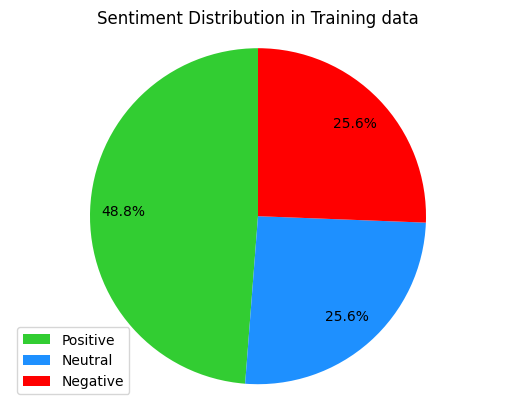

Total word count:  601893
Average review length: 601893.00

Analyzing Validation data
3 (Positive): 10000 reviews (86.66%)
2 (Neutral): 790 reviews (6.85%)
1 (Negative): 750 reviews (6.50%)


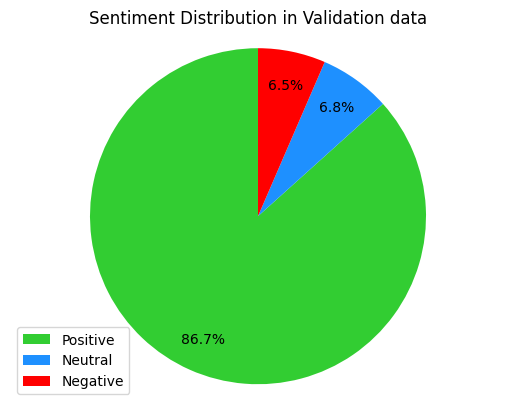

Total word count:  256479
Average review length: 256479.00

Analyzing Testing data
3 (Positive): 10000 reviews (83.89%)
2 (Neutral): 991 reviews (8.31%)
1 (Negative): 930 reviews (7.80%)


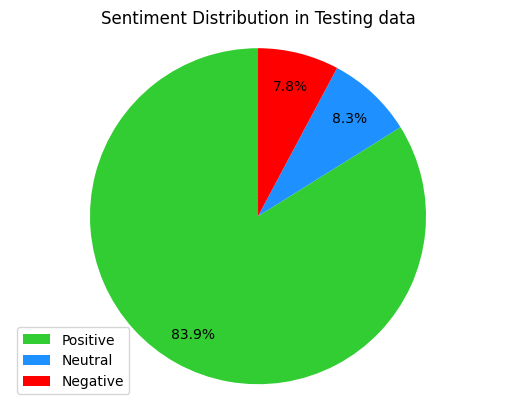

Total word count:  262523
Average review length: 262523.00



In [18]:
print_split_dist(x_train_balanced, x_val_undersampled, x_test_undersampled)
analyse_data(x_train_balanced, y_train_balanced, "Training", plot=True)
analyse_data(x_val_undersampled, y_val_undersampled, "Validation", plot=True)
analyse_data(x_test_undersampled, y_test_undersampled, "Testing", plot=True)

In [19]:
# Change naming 
x_train = x_train_balanced.copy()
y_train = y_train_balanced.copy()

x_val = x_val_undersampled.copy()
y_val = y_val_undersampled.copy()

x_test = x_test_undersampled.copy()
y_test = y_test_undersampled.copy()

In [20]:
# Save data as DataFrame
merge_data(x_train, y_train).to_csv(os.path.join(folder_path, "train.csv"), sep=',', index_label='Id')
merge_data(x_val, y_val).to_csv(os.path.join(folder_path, "val.csv"), sep=',', index_label='Id')
merge_data(x_test, y_test).to_csv(os.path.join(folder_path, "test.csv"), sep=',', index_label='Id')